In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import glob
import dask
import matplotlib
import scipy.special as sps  
import xagg as xa
import pickle

In [ ]:
# from dask.distributed import Client, progress
# client = Client(threads_per_worker=1,
#                 n_workers=8, memory_limit='8GB')
from dask.distributed import Client
client = Client(n_workers=8)
client

# Preprocess

In [ ]:
# swe

In [105]:
data_vars = ['H2OSNO']

def preprocess(ds):
    return ds[data_vars]
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'

casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))
h1_opt = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
h1_opt = h1_opt[data_vars[0]].compute()
h1_opt.to_netcdf('/glade/derecho/scratch/elkoukah/pipeline/%s_%s.nc'%(data_vars[0],casename))

casename = 'CR_conus404_newsurfdata_default.002'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))
h1_base = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
h1_base = h1_base[data_vars[0]].compute()
h1_base.to_netcdf('/glade/derecho/scratch/elkoukah/pipeline/%s_%s.nc'%(data_vars[0],casename))

KeyboardInterrupt: 

In [ ]:
data_vars = ['H2OSNO']

def preprocess(ds):
    return ds[data_vars]
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'

casename = 'CA_conus404_newsurfdata_asmo.opt_001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))
h1_opt = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
h1_opt = h1_opt[data_vars[0]].compute()
h1_opt.to_netcdf('/glade/derecho/scratch/elkoukah/pipeline/%s_%s.nc'%(data_vars[0],casename))

casename = 'CA_conus404_asmo_newsurfdata_default.001'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h1.*.nc'))
h1_base = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
h1_base = h1_base[data_vars[0]].compute()
h1_base.to_netcdf('/glade/derecho/scratch/elkoukah/pipeline/%s_%s.nc'%(data_vars[0],casename))

In [2]:
# Read Preprocess:

In [106]:
casename = 'CA_conus404_newsurfdata_asmo.opt_001'
fsno_opt_ca = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/FSNO_%s.nc'%casename).load()
casename = 'CA_conus404_asmo_newsurfdata_default.001'
fsno_base_ca = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/FSNO_%s.nc'%casename).load()

casename = 'CA_conus404_newsurfdata_asmo.opt_001'
h2osno_opt_ca = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/H2OSNO_%s.nc'%casename).load()
casename = 'CA_conus404_asmo_newsurfdata_default.001'
h2osno_base_ca = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/H2OSNO_%s.nc'%casename).load()

In [107]:
casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
fsno_opt_cr = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/fsno_%s.nc'%casename).load()
casename = 'CR_conus404_newsurfdata_default.002'
fsno_base_cr = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/fsno_%s.nc'%casename).load()

casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
h2osno_opt_cr = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/H2OSNO_%s.nc'%casename).load()
casename = 'CR_conus404_newsurfdata_default.002'
h2osno_base_cr = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/H2OSNO_%s.nc'%casename).load()

In [108]:
# Change lon
h2osno_base_ca['lon'] = h2osno_base_ca['lon']-360
h2osno_opt_cr['lon'] = h2osno_opt_cr['lon']-360
h2osno_base_cr['lon'] = h2osno_base_cr['lon']-360

fsno_base_ca['lon'] = fsno_base_ca.lon-360
fsno_base_cr['lon'] = fsno_base_cr.lon-360
fsno_opt_cr['lon'] = fsno_opt_cr.lon-360

In [109]:
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
ca_gdf = gpd.read_file(shapfile)
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/colorado_river_basin.shp'
cr_gdf = gpd.read_file(shapfile)

In [110]:
ds_stations = xr.open_dataset('/glade/work/elkoukah/inputs/obs/snowPillowSWE_westernNA_level2_ncc.nc')

In [111]:
from shapely.geometry import Polygon
def grid_polygon_intersect(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res),
                      (x-res, y+res),
                      (x+res, y+res),
                      (x+res,y-res),
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    print('searching for grid intersections ...')
    for ii in range(ngrd):
        mask[ii] = geom.intersects(gridcells[ii])
    print('intersecting grid total:', mask.sum(), 'out of', ngrd)
    return mask

In [112]:
# Select stations within domain
res = 0.02
lons, lats = ds_stations['longitude'][0].data, ds_stations['latitude'][0].data
lons[np.isnan(lons)] = 0.0
lats[np.isnan(lats)] = 0.0
mask_ca = grid_polygon_intersect(lats, lons, res, ca_gdf.geometry)
mask_cr = grid_polygon_intersect(lats, lons, res, cr_gdf.geometry)

searching for grid intersections ...
intersecting grid total: 133 out of 1065
searching for grid intersections ...
intersecting grid total: 194 out of 1065


In [113]:
# Select grids with stations
def sel_sites(da,x,y, site_id):
    data = []
    for i,j in zip (x,y):
        data.append(da.sel(lon=i, lat=j, method='nearest').data)
    daout = xr.DataArray(np.stack(data), dims=('site', 'time'), coords={'time':da.time,'site':site_id})
    return daout
h2osno_opt_ca_sites = sel_sites(h2osno_opt_ca, lons[mask_ca>0], lats[mask_ca>0], np.where(mask_ca)[0])
h2osno_base_ca_sites = sel_sites(h2osno_base_ca, lons[mask_ca>0], lats[mask_ca>0], np.where(mask_ca)[0])
h2osno_opt_cr_sites = sel_sites(h2osno_opt_cr, lons[mask_cr>0], lats[mask_cr>0], np.where(mask_cr)[0])
h2osno_base_cr_sites = sel_sites(h2osno_base_cr, lons[mask_cr>0], lats[mask_cr>0], np.where(mask_cr)[0])
h2osno_opt_sites = xr.concat([h2osno_opt_ca_sites, h2osno_opt_cr_sites], dim='site')
h2osno_base_sites = xr.concat([h2osno_base_ca_sites, h2osno_base_cr_sites], dim='site')
h2osno_opt_sites.name = 'opt'
h2osno_base_sites.name = 'base'

In [114]:
# Observations
mask = (mask_ca+mask_cr)>0
ds_tag = ds_stations.sel(sites=mask)
time = pd.date_range('1960-10-01','2019-09-01')
datenum = ds_tag['date_matlab'][:,0,:].data.ravel()
swel2 = ds_tag['swe_level2'].data.transpose(1,0,2)
swel2 = swel2.reshape(-1,59*366)
swel2 = swel2[:, ~np.isnan(datenum)]
swel2_stations = xr.DataArray(swel2, dims=('site', 'time'), 
                              coords={'time':time, 'site':np.where(mask)[0]}, name='obs')

In [115]:
tdelta = slice('2004-10-01', '2019-09-30')
swe_dict = {'obs':swel2_stations.sel(time=tdelta), 
            'base':h2osno_base_sites.sel(time=tdelta), 
            'opt':h2osno_opt_sites.sel(time=tdelta),
           }
pickle.dump(swe_dict, open('out/swe_dict.pkl', 'wb'))
ds_tag.to_netcdf('out/swe_stations_sel.nc')

In [ ]:
# SCF

In [15]:
casename = 'CA_conus404_newsurfdata_asmo.opt_001'
fsno_opt_ca = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/FSNO_%s.nc'%casename).load()
casename = 'CA_conus404_asmo_newsurfdata_default.001'
fsno_base_ca = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/FSNO_%s.nc'%casename).load()

casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
fsno_opt_cr = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/fsno_%s.nc'%casename).load()
casename = 'CR_conus404_newsurfdata_default.002'
fsno_base_cr = xr.open_dataarray('/glade/derecho/scratch/elkoukah/pipeline/fsno_%s.nc'%casename).load()

fsno_base_ca['lon'] = fsno_base_ca.lon-360
fsno_base_cr['lon'] = fsno_base_cr.lon-360
fsno_opt_cr['lon'] = fsno_opt_cr.lon-360

fsno_base_cr['time'] = fsno_base_cr.time.astype('datetime64[ns]')
fsno_opt_cr['time'] = fsno_opt_cr.time.astype('datetime64[ns]')
fsno_base_ca['time'] = fsno_base_ca.time.astype('datetime64[ns]')
fsno_opt_ca['time'] = fsno_opt_ca.time.astype('datetime64[ns]')

In [16]:
ucrb_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU8.shp')
lcrb_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU8.shp')
ca_huc8 = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU8.shp')

sw_huc8 = pd.concat([ucrb_huc8,lcrb_huc8,ca_huc8])
sw_huc8_wgs84 = sw_huc8.to_crs(epsg=4326)
n = len(sw_huc8_wgs84)

In [17]:
# Baseline

In [18]:
dict_ds_baseline = {}
for i,row in sw_huc8_wgs84.iterrows():
    # print('processing', i, 'out of', n)
    minx, miny, maxx, maxy = row.geometry.bounds
    if row['huc8'].startswith('14'):
        fsno_base = fsno_base_cr.sel(lat=slice(miny,maxy), lon=slice(minx,maxx))
        # fsno_opt = fsno_opt_cr.sel(time=time, lat=slice(miny,maxy), lon=slice(minx,maxx))
    elif row['huc8'].startswith('18'):
        fsno_base = fsno_base_ca.sel(lat=slice(miny,maxy), lon=slice(minx,maxx))
        # fsno_opt = fsno_opt_ca.sel(time=time, lat=slice(miny,maxy), lon=slice(minx,maxx))
    fsno_base_aave = fsno_base.mean(axis=(1,2))
    time = fsno_base_aave.time
    dict_ds_baseline[row['huc8']] = xr.Dataset({'base':(('time','huc8'), fsno_base_aave.data[:, None])}, 
                                               coords={'time':time})

In [19]:
# dict_ds_avhrr = pickle.load(open('/glade/derecho/scratch/elkoukah/pipeline/avhrr_mdl_huc8_sw.pkl', 'rb'))
dict_ds_avhrr = pickle.load(open('/glade/derecho/scratch/elkoukah/pipeline/avhrr_mdl_huc8_sw_nearest.pkl', 'rb'))
dict_ds_modis = pickle.load(open('/glade/derecho/scratch/elkoukah/pipeline/modis_mdl_huc8_sw_nearest.pkl', 'rb'))
dict_ds_avhrr_sp = pickle.load(open('/glade/derecho/scratch/elkoukah/pipeline/avhrr_mdl_huc8_sw_nearest_spatial.pkl', 'rb'))
dict_ds_modis_sp = pickle.load(open('/glade/derecho/scratch/elkoukah/pipeline/modis_mdl_huc8_sw_nearest_spatial.pkl', 'rb'))

In [20]:
tdelta_snw = slice('2000-10-01','2018-09-30')

In [21]:
# mKGE
def calc_mkge(x,y):
    r2 = np.mean((y.T-y.mean()).T*(x-x.mean()))/(y.std()*x.std())
    beta = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta**2))
    return mkge, r2, beta, sigma

sw_huc8_index = sw_huc8.set_index('huc8')
sw_huc8_index_sp = sw_huc8.set_index('huc8')

for i,key in enumerate(dict_ds_modis.keys()):
    ifsno = dict_ds_modis[key].sel(time=tdelta_snw)
    xx = ifsno['modis'][:,0].data
    ma = ~np.isnan(xx)
    xx = xx[ma]
    yy_base = ifsno['base'][:,0].data[ma]
    yy_opt = ifsno['opt'][:,0].data[ma]
    mkge_base_1, r2_base_1, beta_base_1, sigma_base_1 = calc_mkge(xx,yy_base)
    mkge_opt_1, r2_opt_1, beta_opt_1, sigma_opt_1 = calc_mkge(xx,yy_opt)
    
    ifsno = dict_ds_avhrr[key].sel(time=tdelta_snw)
    xx = ifsno['avhrr'][:,0].data
    ma = ~np.isnan(xx)
    xx = xx[ma]
    yy_base = ifsno['base'][:,0].data[ma]
    yy_opt = ifsno['opt'][:,0].sel(time=tdelta_snw).data[ma]
    mkge_base_2, r2_base_2, beta_base_2, sigma_base_2 = calc_mkge(xx,yy_base)
    mkge_opt_2, r2_opt_2, beta_opt_2, sigma_opt_2 = calc_mkge(xx,yy_opt)
    
    sw_huc8_index.loc[key, ['mkge_base', 'r2_base', 'beta_base', 'sigma_base']] = [(mkge_base_1+mkge_base_2)/2, 
                                                                                   (r2_base_1+r2_base_2)/2, 
                                                                                   (beta_base_1+beta_base_2)/2, 
                                                                                   (sigma_base_1+sigma_base_2)/2]
    sw_huc8_index.loc[key, ['mkge_opt', 'r2_opt', 'beta_opt', 'sigma_opt']] =  [(mkge_opt_1+mkge_opt_2)/2, 
                                                                                   (r2_opt_1+r2_opt_2)/2, 
                                                                                   (beta_opt_1+beta_opt_2)/2, 
                                                                                   (sigma_opt_1+sigma_opt_2)/2]
    yytmp = dict_ds_baseline[key]['base'].data
    sw_huc8_index.loc[key, 'fsno_0p1'] = (yytmp>=.1).sum()/yytmp.size

for i,key in enumerate(dict_ds_modis_sp.keys()):
    ifsno = dict_ds_modis_sp[key]
    xx = ifsno['modis'].data
    ma = ~np.isnan(xx)
    xx = xx[ma]
    yy_base = ifsno['base'].data[ma]
    yy_opt = ifsno['opt'].data[ma]
    mkge_base_1, r2_base_1, beta_base_1, sigma_base_1 = calc_mkge(xx,yy_base)
    mkge_opt_1, r2_opt_1, beta_opt_1, sigma_opt_1 = calc_mkge(xx,yy_opt)
    
    ifsno = dict_ds_avhrr_sp[key]
    xx = ifsno['avhrr'].data
    ma = ~np.isnan(xx)
    xx = xx[ma]
    yy_base = ifsno['base'].data[ma]
    yy_opt = ifsno['opt'].data[ma]
    mkge_base_2, r2_base_2, beta_base_2, sigma_base_2 = calc_mkge(xx,yy_base)
    mkge_opt_2, r2_opt_2, beta_opt_2, sigma_opt_2 = calc_mkge(xx,yy_opt)
    
    sw_huc8_index_sp.loc[key, ['mkge_base', 'r2_base', 'beta_base', 'sigma_base']] = [(mkge_base_1+mkge_base_2)/2, 
                                                                                   (r2_base_1+r2_base_2)/2, 
                                                                                   (beta_base_1+beta_base_2)/2, 
                                                                                   (sigma_base_1+sigma_base_2)/2]
    sw_huc8_index_sp.loc[key, ['mkge_opt', 'r2_opt', 'beta_opt', 'sigma_opt']] =  [(mkge_opt_1+mkge_opt_2)/2, 
                                                                                   (r2_opt_1+r2_opt_2)/2, 
                                                                                   (beta_opt_1+beta_opt_2)/2, 
                                                                                   (sigma_opt_1+sigma_opt_2)/2]
    yytmp = dict_ds_baseline[key]['base'].data
    sw_huc8_index_sp.loc[key, 'fsno_0p1'] = (yytmp>=.1).sum()/yytmp.size
    # sw_huc8_index_sp.loc[key, 'fsno_0p1'] = (yy_base>=0.25).sum()/xx.size

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeW

In [22]:
scf_kge_dict = {'sw_huc8_index_sp':sw_huc8_index_sp, 'sw_huc8_index':sw_huc8_index}
pickle.dump(scf_kge_dict, open('out/scf_kge_dict.pkl', 'wb'))

# Visualize

In [3]:
# figure
import matplotlib.gridspec as gridspec

In [4]:
swe_dict = pickle.load(open('out/swe_dict.pkl', 'rb'))
scf_kge_dict = pickle.load(open('out/scf_kge_dict.pkl', 'rb'))

In [5]:
swe_stations_data = xr.open_dataset('out/swe_stations_sel.nc')

In [6]:
sw_huc8_index = scf_kge_dict['sw_huc8_index']
sw_huc8_index_sp = scf_kge_dict['sw_huc8_index_sp']
gdf_plot = sw_huc8_index[sw_huc8_index['fsno_0p1']>=0.15]
gdf_plot_sp = sw_huc8_index_sp[sw_huc8_index['fsno_0p1']>=0.15]

In [7]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU2.shp'
gdf_ucrb = gpd.read_file(shapefile)
gdf_ucrb_crs = gdf_ucrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
gdf_lcrb = gpd.read_file(shapefile)
gdf_lcrb_crs = gdf_lcrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
gdf_ca = gpd.read_file(shapefile)
gdf_ca_crs = gdf_ca.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
gdf_sw = gpd.read_file(shapefile)
gdf_sw_crs = gdf_sw.to_crs(ccrs.PlateCarree())

cbar_ticks = {'mkge':np.arange(0., .91, .2),
              'sigma':np.array([0.5 , 0.75, 0.85, 1.15, 1.25, 1.5 ]),
              'beta':np.array([-0.5 , -0.25, -0.1, 0.1, 0.25, 0.5]),
              'r2':np.arange(0., .91, .1)[5:],}
labels = {'mkge':r"KGE$^{''}$",
          # 'mkge':r"modified Kling–Gupta efficiency (KGE$^{''}$)",
          'r2':'$r$',
          'sigma':r'$\alpha$',
          'beta':r'$\beta$',
         }
extent = (-124.6, -105.6, 30.02, 43.46)

states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                        name='admin_1_states_provinces_lines',
                                        scale='50m',
                                        facecolor='none')

In [8]:
metric = 'r2'
cmap = 'Blues' #'PiYG'
norm = matplotlib.colors.BoundaryNorm(boundaries=cbar_ticks[metric], ncolors=256, extend='both')
ticks = cbar_ticks[metric]
label = labels[metric]

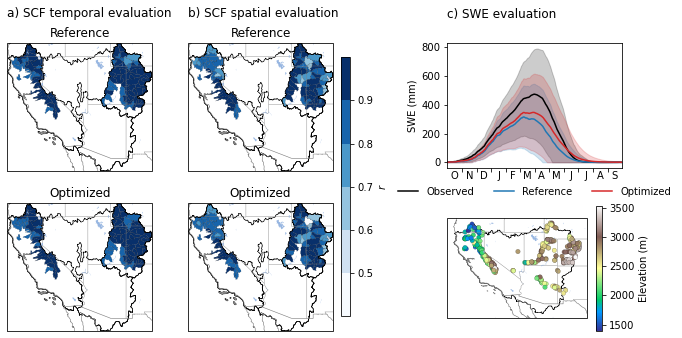

In [9]:
fig = plt.figure(figsize=(11,5))
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.1,right=0.625,top=0.9,bottom=0.1,wspace=0.1,hspace=0.25)

titles = ['a) SCF temporal evaluation', 'b) SCF spatial evaluation']
subtitles = ['Reference', 'Optimized']
gs1_axes = []
for i, sim in enumerate(['base','opt']):
    for j, gdfj in enumerate([gdf_plot, gdf_plot_sp]):
        ax = plt.subplot(gs1[i,j],projection=ccrs.PlateCarree())
        gs1_axes.append(ax)
        ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
        ax.add_feature(cfeature.BORDERS, edgecolor='gray', lw=.6)
        ax.add_feature(cfeature.LAKES, edgecolor='None', lw=.1)
        ax.add_feature(cfeature.COASTLINE, edgecolor='gray', lw=.6)
        gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
        ax.set_extent(extent)
        ax.set_title(subtitles[i])
        fc = gdfj.plot(ax=ax, column=f'{metric}_{sim}', cmap=cmap, norm=norm, edgecolor='k', lw=.1, zorder=-1)
        # break
    # break
gs1_axes[0].annotate(titles[0], (0,1.2), xycoords='axes fraction', fontsize=12)
gs1_axes[1].annotate(titles[1], (0,1.2), xycoords='axes fraction', fontsize=12)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm,ax=gs1_axes,location='right',aspect=30, shrink=.9, ticks=ticks, extendfrac='auto', extendrect=True, pad=0.02)
cb.set_label(label)

gs2 = gridspec.GridSpec(2,1)
gs2.update(left=0.68,right=0.9,top=0.9,bottom=0.1,wspace=0.25,hspace=0.3)
ax = plt.subplot(gs2[1,0],projection=ccrs.PlateCarree())
ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', lw=.6)
ax.add_feature(cfeature.LAKES, edgecolor='None', lw=.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='gray', lw=.6)
gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')

yy = swe_stations_data['latitude'].data[0]
xx = swe_stations_data['longitude'].data[0]
zz = swe_stations_data['elevation'].data[0]
sc = ax.scatter(xx, yy, c=zz, cmap='terrain', edgecolor='k', lw=.15, s=20)
cb2 = plt.colorbar(sc, ax=ax)
cb2.set_label('Elevation (m)')

ax = plt.subplot(gs2[0,0])
days = np.arange(365)
idx = np.append(days[273:],days[:273])
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])
legend = ['Observed', 'Reference', 'Optimized']
colors = ('k', 'tab:blue', 'tab:red')
for i, m in enumerate(('obs', 'base', 'opt')): 
    da = swe_dict[m]
    swe_doy = da.groupby('time.dayofyear').mean()
    mu = swe_doy.mean('site')
    sigma = swe_doy.std('site')
    swe_min = swe_doy.min('site')
    swe_max = swe_doy.max('site')
    
    
    ax.plot(mu.data[idx], label=legend[i], color=colors[i], markersize=2)
    ax.fill_between(days, np.max(np.stack([mu-sigma, np.zeros((mu.size,))]), axis=0)[idx], (mu+sigma)[idx], color=colors[i], alpha=0.2)
    # ax.fill_between(days, swe_min.data[idx], swe_max[idx], color='k', alpha=0.2)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)
    ax.margins(x=0)
ax.set_ylabel('SWE (mm)')
ax.legend(ncol=3, loc='lower center', bbox_to_anchor=(.5,-0.3), frameon=False)

ax.annotate('c) SWE evaluation', (0,1.2), xycoords='axes fraction', fontsize=12);


In [39]:
fig.savefig('figs/scf_swe_v01.png', dpi=300, bbox_inches='tight')

In [2]:
# Poster fig

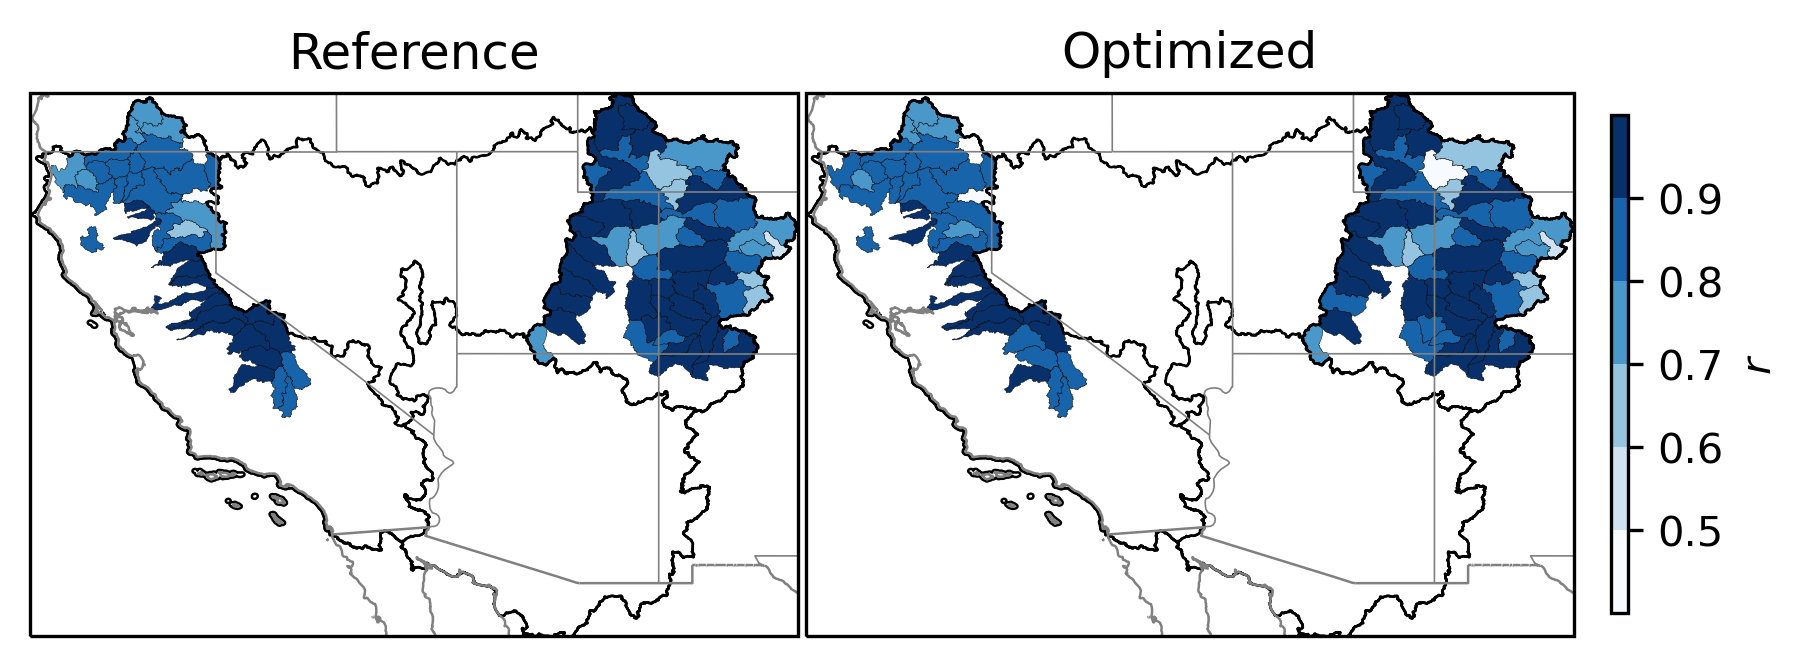

In [40]:
# fig = plt.figure(figsize=(11,5))
fig, axes = plt.subplots(1, 2, subplot_kw={'projection':ccrs.PlateCarree()}, gridspec_kw={'wspace':.01}, figsize=(8,4), dpi=300)

titles = ['a) SCF temporal evaluation', 'b) SCF spatial evaluation']
subtitles = ['Reference', 'Optimized']
gs1_axes = []
for i, sim in enumerate(['base','opt']):
    ax = axes[i]
    gdfj = gdf_plot_sp.to_crs(ccrs.PlateCarree())
    ax.add_feature(states_provinces, edgecolor='gray', lw=.4)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', lw=.6)
    # ax.add_feature(cfeature.LAKES, edgecolor='None', lw=.1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='gray', lw=.6)
    gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    ax.set_extent(extent)
    ax.set_title(subtitles[i])
    fc = gdfj.plot(ax=ax, column=f'{metric}_{sim}', cmap=cmap, norm=norm, edgecolor='k', lw=.1, zorder=-1)
    
# axes[0].annotate(titles[0], (0,1.2), xycoords='axes fraction', fontsize=12)
# axes[1].annotate(titles[1], (0,1.2), xycoords='axes fraction', fontsize=12)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm,ax=axes,location='right',aspect=30, shrink=.55, ticks=ticks, extendfrac='auto', extendrect=True, pad=0.02)
cb.set_label(label)